/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


🔍 Best SVR Parameters: {'C': 1, 'degree': 2, 'epsilon': 0.01, 'kernel': 'linear'}
📈 SVR → RMSE: 0.0237, R²: 0.9993

🌳 Best Decision Tree Parameters: {'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_split': 5}
📈 Decision Tree → RMSE: 0.3382, R²: 0.8617


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


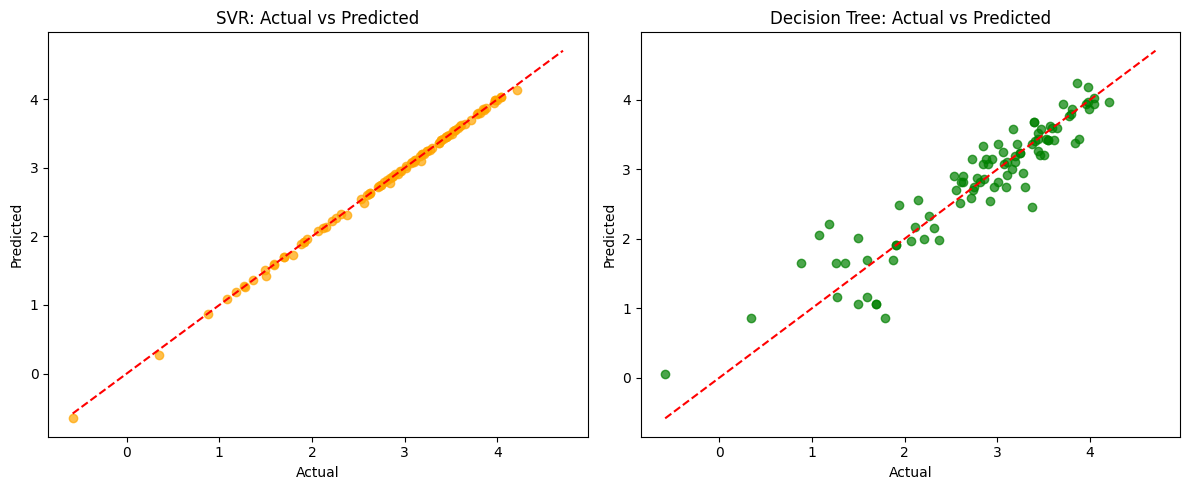

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_excel("raw data.xlsx")

# Encode categorical values
df['Teacher_Support'] = df['Teacher_Support'].map({'Low': 1, 'Medium': 2, 'High': 3}).fillna(2)
df['Peer_Influence'] = df['Peer_Influence'].map({'Negative': 1, 'Neutral': 2, 'Positive': 3}).fillna(2)

# Feature engineering
scaler_marks = MinMaxScaler()
df['Marks_Score'] = scaler_marks.fit_transform(df[['Marks']])

df['Attendance_Score'] = df['Attendance'] / 4
df['Sleep_Score'] = df['Sleep_Hours'] / 3
df['Health_Score'] = df['Physical_Health'] / 5
df['Motivation_Score'] = df['Teacher_Support'].map({1: 0.3, 2: 0.6, 3: 1.0})
df['Stress_Score'] = df['Late_submissions'] / 3

# Final performance score
df['Performance_Score'] = (
    df['Sleep_Score'] +
    df['Health_Score'] +
    df['Marks_Score'] +
    df['Attendance_Score'] +
    df['Motivation_Score'] -
    df['Stress_Score']
)

# Features and target
features = [
    'Sleep_Hours', 'Physical_Health', 'Study_Resources', 'Marks',
    'Attendance', 'Late_submissions', 'Consistency',
    'Teacher_Support', 'Peer_Influence'
]
X = df[features]
y = df['Performance_Score']

# Scaling
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# svr  
svr_params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'degree': [2, 3]  # only used in poly
}

svr = SVR()
grid_svr = GridSearchCV(svr, svr_params, cv=5, scoring='r2')
grid_svr.fit(X_train, y_train)

best_svr = grid_svr.best_estimator_
svr_pred = best_svr.predict(X_test)
svr_rmse = mean_squared_error(y_test, svr_pred, squared=False)
svr_r2 = r2_score(y_test, svr_pred)

# decision tree
tree_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
}

dt = DecisionTreeRegressor(random_state=42)
grid_dt = GridSearchCV(dt, tree_params, cv=5, scoring='r2')
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
dt_pred = best_dt.predict(X_test)
dt_rmse = mean_squared_error(y_test, dt_pred, squared=False)
dt_r2 = r2_score(y_test, dt_pred)

# results
print("🔍 Best SVR Parameters:", grid_svr.best_params_)
print(f"📈 SVR → RMSE: {svr_rmse:.4f}, R²: {svr_r2:.4f}")

print("\n🌳 Best Decision Tree Parameters:", grid_dt.best_params_)
print(f"📈 Decision Tree → RMSE: {dt_rmse:.4f}, R²: {dt_r2:.4f}")

# Plot actual vs predicted for both
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, svr_pred, alpha=0.7, color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('SVR: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_test, dt_pred, alpha=0.7, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Decision Tree: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()
